In the newest JupyterLab, you can use arrow keys to expand or collapse the headings!

# 1. Single-Qubit Gates

## Setup

In [1]:
#========================
# PLEASE RUN THIS CELL!
#========================
from IPython.display import display,HTML,Markdown
display(HTML('''
<style>
h1 { background-color: #AEA; padding: 0.8ex 0.8ex 0.5ex 0.8ex; border: 2px solid #8C8; }
h2 { background-color: #AEE; padding: 0.8ex 0.8ex 0.5ex 0.8ex; border: 2px solid #9CC; }
h3 { background-color: #EEA; padding: 0.8ex 0.8ex 0.5ex 0.8ex; border: 2px solid #CC9; }
</style>'''))
display(Markdown(r'''
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\mat}[1]{\underline{\underline{\mathbf{#1}}}}$
'''))

from collections.abc import Iterable
import numpy as np; from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import regex as re
import qiskit,qiskit_aer
import qiskit.visualization as qisvis
from qiskit.providers.fake_provider import fake_provider
vigoBackend = fake_provider.FakeVigo()
rng = random.default_rng()
cirStyle = {'fontsize':24, 'linecolor':'#999', 'displaycolor': {'cx':'#06C', 'ccx':'#06C', 'mcx':'#06c', 'cswap':'#06C'}}
cirOpts={'fold':-1, 'style':cirStyle}

def bstrFromList (bitlist):
  try:    return ''.join([str(c) for c in bitlist[::-1]])
  except: return bitlist
def bstrFromInteger (thing, numBits=-1):
  if numBits==-1:
    return bin(thing)[2:]
  else:
    return bin(thing)[2:].zfill(numBits)
def bstr (thing, numBits=-1):
  if isinstance (thing, Iterable):
    return bstrFromList(thing)
  else:
    return bstrFromInteger(thing, numBits)
def dstrFromString (thing):
  if isinstance(thing,str):
    numDigits = len(thing)
    fmt = '{:' + str(numDigits) + 'd}'
    return fmt.format (int(thing,2))
def dstr (thing):
  return dstrFromString (thing)

def padCounts(cts, numBits):
  def sanitize(count): return (0 if count==None else count)
  n = numBits
  return {bstr(i,n):sanitize(cts.get(bstr(i,n))) for i in range(2**n)}
def getStatevector (res, svName='Statevector'):
  return np.asarray(res.data() [svName])
def getStatevectors (res, pattern='psi'):
  dat = res.data()
  svNames = [key for key in dat.keys() if re.search(pattern, key)]
  svNames.sort()
  return np.asarray([dat[svName] for svName in svNames])
def plotStatevector(psi,ax='auto',figsize='auto',horiz=False,cmap=mpl.cm.hsv,tickInterval=1):
  #======== Determine dimensions
  nmax = int(np.log(len(psi)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  probs = np.abs(psi)**2
  phases = np.remainder(np.angle(psi) / (2*np.pi), 1)
  #======== If user hasn't supplied an ax, create one now
  if ax=='auto':
    if figsize=='auto':
      figsize = (2,6) if horiz else (6,1)
    fig,ax = plt.subplots(figsize=figsize)
  #======== Plot
  if horiz:
    for l in range(lmax):
      patch = patches.Rectangle([0,-l-1], probs[l],1, ec='black', fc=cmap(phases[l]))
      ax.add_patch(patch)
    ax.set_yticks([-l-1+.5 for l in range(0,lmax,tickInterval)])
    ax.set_yticklabels([bstr(l,nmax) for l in range(0,lmax,tickInterval)])
    ax.set_ylim(-lmax-.5, .5)
    ax.set_xlim(0, max(probs)*1.1)
  else:
    for l in range(lmax):
      patch = patches.Rectangle([l,0], 1,probs[l], ec='black', fc=cmap(phases[l]))
      ax.add_patch(patch)
    ax.set_xticks([l+.5 for l in range(lmax)])
    ax.set_xticklabels([bstr(l,nmax) for l in range(lmax)])
    ax.set_xlim(-.5, lmax+.5)
    ax.set_ylim(0, max(probs)*1.1)
    
def plotHistogram(counts,ax='auto',figsize='auto',horiz=False,fc='#9cf',textrot=0):
  #======== Pad counts
  if isinstance (counts, dict):
    nmax = len(list(counts.keys()) [0] )
    counts = padCounts(counts,nmax)
    counts = list(counts.values())
  #======== Determine dimensions
  nmax = int(np.log(len(counts)) / np.log(2)) # number of qubits
  lmax = 2**nmax                              # number of states
  ymax = max(counts)
  #======== If user hasn't supplied an ax, create one now
  if ax=='auto':
    if figsize=='auto':
      figsize = (2,6) if vertical else (6,1)
    fig,ax = plt.subplots(figsize=figsize)
  #======== Plot
  if vertical:
    for l in range(lmax):
      c = counts[l]
      patch = patches.Rectangle([0,-l-1], c,1, ec='black', fc=fc)
      ax.add_patch(patch)
      if c>0:
        y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
        ax.text (y, -l-1+.5, c, va='center',ha='center')
    ax.set_yticks([-l-1+.5 for l in range(lmax)])
    ax.set_yticklabels([bstr(l,nmax) for l in range(lmax)])
    ax.set_ylim(-lmax-.5, .5)
    ax.set_xlim(0, ymax*1.02)
  else:
    for l in range(lmax):
      c = counts[l]
      patch = patches.Rectangle([l,0], 1,c, ec='black', fc=fc)
      ax.add_patch(patch)
      if c>0:
        y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
        ax.text (l+.5, y, c, va='center',ha='center')
    ax.set_xticks([l+.5 for l in range(lmax)])
    ax.set_xticklabels([bstr(l,nmax) for l in range(lmax)])  
    ax.tick_params(axis='x', labelrotation=textrot)
    ax.set_xlim(-.5, lmax+.5)
    ax.set_ylim(0, ymax*1.02)

def circuitSize (cir, scaleFactor=0.4):
  '''
  Given a qiskit.Circuit, return a tuple (width,height)
  representing the "standard size" of that circuit in inches 
  '''
  fig,ax=plt.subplots(1,1,figsize=(1,1))   # temporary
  cir.draw('mpl',ax=ax,fold=-1)
  bbox = ax.get_tightbbox(fig.canvas.get_renderer()); aspect = bbox.height/bbox.width
  yrange = np.ptp(ax.get_ylim()); h = yrange*scaleFactor; w=h/aspect
  plt.close()
  return (w,h)

def subplotRow (widths=[1,2,3,2], heights=[2,2,2,2]):
  '''
  Make a row of subplots with the given widths and heights (in inches)
  '''
  assert len(widths)==len(heights)
  numPanels = len(widths)
  width = np.sum (widths)
  height = np.max (heights)
  fig,axs=plt.subplots(1,numPanels,figsize=(width,height))
  xcur = 0
  for n in range(numPanels):
    axs[n].set_position ([xcur, .5 - heights[n]/height/2, widths[n]/width, heights[n]/height])
    xcur += widths[n]/width
  return fig,axs

def draw (cir, **kwargs):
  #print (circuitSize(cir))
  fig,ax=plt.subplots(figsize=circuitSize(cir))
  cir.draw('mpl',**kwargs,**cirOpts,ax=ax)

def initRegister (cir, register, value):
  '''
  Add instructions to circuit <cir> to XOR register <register> with an integer <value>
  '''
  for i in range(register.size):
    if (value>>i)&1:
      cir.x(register[i])

sim = qiskit_aer.AerSimulator()                         # run this line if you want to use ideal simulator
#sim = qiskit_aer.AerSimulator.from_backend(vigoBackend) # uncomment and run if you want to use a noisy simulator based on IBM's Vigo machine


$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\mat}[1]{\underline{\underline{\mathbf{#1}}}}$


In [2]:
def axgrid (widths=4, heights=2, ha=.5, va=.5, bottomtotop=False, labels=None, removeticks=True, padl=0, padt=0):
  '''
  Make a Figure and an array of Axes, arranged in a grid layout.
  
  Examples:
  
  >>> axgrid (3,1)                      # One plot of size 3x1
  >>> axgrid ([1,4,2,3], [1])           # One row of plots, all of height 1
  >>> axgrid (6, [.2, .4, .2])          # One column of plots
  >>> axgrid ([.2,3,3], [.2,.4,.4,.4])  # Grid with unequal widths and heights
  >>> axgrid ([.2,3,3], [.2,.4,.4,.4], bottomtotop=True) # Reverse vertical order of plots
  
  If *widths* and *heights* are both 2D arrays, some of the plots may be smaller than the allotted grid cell.
  In this case, *ha* and *va* determine horizontal alignment and vertical alignment.  For example:
  
  >>> axgrid ([[2,2,3],[2,3,2]], [[1,1,1],[2,1,2]], ha='left', va='top', labels='auto')
  
  Rows are usually in top-to-bottom order.  This may be reversed using the *bottomtotop* argument:
  
  >>> axgrid ([[2,2,3],[2,3,2]], [[1,1,1],[2,1,2]], ha='right', va='center', labels='auto', bottomtotop=True)
  
  In order to address the Figure and Axes objects, one should save the return values:
  
  >>> fig,axs = axgrid ([[2,2,3],[2,3,2]], [[1,1,1],[2,1,2]], removeticks=False)
  >>> ax = axs[0,0]; ax.plot ([1,2],[1,2])
  >>> ax = axs[1,2]; ax.plot ([1,2],[1,2]);
  
  The Axes in row i and column j is axs[i,j].  It has size width[i,j] x height[i,j].
  These conventions are consistent with matrix indexing conventions (and plt.subplots and numpy.ndarray)
  Generally, where indices are concerned, row indices are quoted before column indices.
  However, where physical dimensions are concerned, widths are quoted before heights,
  according to the conventional ordering of Cartesian coordinates (x,y) (and plt.plot).
  
  Parameters
  ----------
  widths, heights : scalar, 1D, or 2D array-like
        
  Returns
  ----------------
  fig, axs : Figure object and numpy.ndarray of Axes objects
  
  Other Parameters
  ----------------
  ha : 'left', 'center', 'right', float between 0 and 1; or 1D or 2D array of such specifications
  va : 'top', 'center', 'bottom', float between 0 and 1; or 1D 2D array of such specifications
  bottomtotop : False (default) or True
  labels : 
    None                  do not draw labels
    'auto'                label each Axes as axs[rowNumber,columnNumber]
    2D array of strings   custom labels to draw in the center of each Axes
  removeticks :
    True                  set each Axes to show only the frame (and no ticks)
    False                 leave Axes tick marks intact
  removeframe : 
    TBD
  '''
  #======== Determine number of grid cells
  wij = np.array (widths) 
  hij = np.array (heights)
  if wij.ndim==0: wij = np.array([wij])
  if hij.ndim==0: hij = np.array([hij])
  jmax = wij.shape[-1]
  imax = hij.shape[0]
  if wij.ndim==1: wij = np.tile (wij, (imax,1))                # Extend 1D to 2D
  if hij.ndim==0: hij = np.tile (hij, (imax,jmax))             # Extend 0D to 2D
  if hij.ndim==1: hij = np.tile (np.array([hij]).T, (1,jmax))  # Extend 1D to 2D
  assert hij.shape == wij.shape,'ERROR: axgrid was supplied with incompatible widths and heights!'
  if not bottomtotop:
    wij = np.flipud (wij)
    hij = np.flipud (hij)
  #======== Deal with padding
  plij = np.array (padl) # padding left
  ptij = np.array (padt)    # padding top
  if plij.ndim==0: plij = np.tile (plij, (imax,jmax))
  if ptij.ndim==0: ptij = np.tile (ptij, (imax,jmax))
  #======== Determine dimensions of grid cells
  wj = np.max (wij + plij, axis=0)
  hi = np.max (hij + ptij, axis=1)
  w = np.sum (wj)
  h = np.sum (hi)
  xj = np.concatenate ([[0], np.cumsum (wj)])
  yi = np.concatenate ([[0], np.cumsum (hi)])
  uij = np.array(ha)   # Array of horizontal alignment pars
  vij = np.array(va)   # Array of vertical alignment pars
  if uij.ndim==0: uij = np.tile (uij, (imax,jmax))
  if uij.ndim==1: uij = np.tile (uij, (imax,1))
  if vij.ndim==0: vij = np.tile (vij, (imax,jmax))
  if vij.ndim==1: vij = np.tile (np.array([vij]).T, (1,jmax))
  for i in range(imax):
    for j in range(jmax):
      if isinstance(uij[i,j],str): uij[i,j] = {'left':0, 'center':0.5, 'right':1}.get(uij[i,j])
      if isinstance(vij[i,j],str): vij[i,j] = {'top':0, 'center':0.5, 'bottom':1}.get(vij[i,j])
  uij = uij.astype (np.float64)
  vij = vij.astype (np.float64)
  #======== Create Axes
  fig,axs = plt.subplots (imax, jmax, figsize=(w,h))
  axs = np.array(axs).reshape ((imax,jmax))   # ensure this is always a imax*jmax numpy array of Axes
  for i in range(imax):
    for j in range(jmax):
      i2 = i if bottomtotop else imax-1-i
      x = (xj[j] + uij[i,j]*(wj[j] - wij[i,j])) / w
      y = (yi[i] + vij[i,j]*(hi[i] - hij[i,j])) / h
      axs[i2,j].set_position ([ x, y, wij[i,j]/w, hij[i,j]/h])
  if isinstance(labels,str) and labels=='auto':
    labels = np.array([[f'axs[{i},{j}]\n{wij[i][j]}x{hij[i][j]}' for j in range(jmax)] for i in range(imax)])
  if removeticks:
    for i in range(imax):
      for j in range(jmax):
        axs[i,j].set_xticks ([])
        axs[i,j].set_yticks ([])
  if isinstance(labels,np.ndarray):
    for i in range(imax):
      for j in range(jmax):
        axs[i,j].text (.5, .5, labels[i,j], ha='center', va='center', fontsize=20)
        axs[i,j].set_facecolor ('#FFFFCC')
  return fig,axs

def modifyAxSize (ax, wnew, hnew):
  wfig,hfig = ax.figure.get_size_inches()
  x0,y0,x1,y1 = ax.get_position().extents
  x0 *= wfig; x1 *= wfig; y0 *= hfig; y1 *= hfig
  x1 = x0 + wnew
  ym = (y0+y1)/2; y0=ym-hnew/2; y1=ym+hnew/2
  x0 /= wfig; x1 /= wfig; y0 /= hfig; y1 /= hfig
  ax.set_position([x0,y0,x1-x0,y1-y0])

## Basic single-qubit gates: X, Y, Z, S, T, H

In [3]:
# def axgrid (widths=4, heights=2, ha=.5, va=.5, bottomtotop=False, labels=None, removeticks=True, padl=0, padt=0):
#   '''
#   Make a Figure and an array of Axes, arranged in a grid layout.
  
#   Examples:
  
#   >>> axgrid (3,1)                      # One plot of size 3x1
#   >>> axgrid ([1,4,2,3], [1])           # One row of plots, all of height 1
#   >>> axgrid (6, [.2, .4, .2])          # One column of plots
#   >>> axgrid ([.2,3,3], [.2,.4,.4,.4])  # Grid with unequal widths and heights
#   >>> axgrid ([.2,3,3], [.2,.4,.4,.4], bottomtotop=True) # Reverse vertical order of plots
  
#   If *widths* and *heights* are both 2D arrays, some of the plots may be smaller than the allotted grid cell.
#   In this case, *ha* and *va* determine horizontal alignment and vertical alignment.  For example:
  
#   >>> axgrid ([[2,2,3],[2,3,2]], [[1,1,1],[2,1,2]], ha='left', va='top', labels='auto')
  
#   Rows are usually in top-to-bottom order.  This may be reversed using the *bottomtotop* argument:
  
#   >>> axgrid ([[2,2,3],[2,3,2]], [[1,1,1],[2,1,2]], ha='right', va='center', labels='auto', bottomtotop=True)
  
#   In order to address the Figure and Axes objects, one should save the return values:
  
#   >>> fig,axs = axgrid ([[2,2,3],[2,3,2]], [[1,1,1],[2,1,2]], removeticks=False)
#   >>> ax = axs[0,0]; ax.plot ([1,2],[1,2])
#   >>> ax = axs[2,1]; ax.plot ([1,2],[1,2]);
  
#   Note that the width of the cell in row r and column c is width[r,c]
#   and the height of the cell in row r and column c is height[r,c], a la numpy.ndarray.
#   In contrast, the Axes in row r and column c is axs[c,r], a la plt.subplots.
    
#   Parameters
#   ----------
#   widths, heights : scalar, 1D, or 2D array-like
        
#   Returns
#   ----------------
#   fig, axs : Figure object and numpy.ndarray of Axes objects
  
#   Other Parameters
#   ----------------
#   ha : 'left', 'center', 'right', float between 0 and 1; or 1D or 2D array of such specifications
#   va : 'top', 'center', 'bottom', float between 0 and 1; or 1D 2D array of such specifications
#   bottomtotop : False (default) or True
#   labels : 
#     None                  do not draw labels
#     'auto'                label each Axes as axs[rowNumber,columnNumber]
#     2D array of strings   custom labels to draw in the center of each Axes
#   removeticks :
#     True                  set each Axes to show only the frame (and no ticks)
#     False                 leave Axes tick marks intact
#   removeframe : 
#     TBD
#   '''
#   #======== Determine grid size
#   wij = np.array (widths) 
#   hij = np.array (heights)
#   if wij.ndim==0: wij = np.array([wij])
#   if hij.ndim==0: hij = np.array([hij])
#   jmax = wij.shape[-1]
#   imax = hij.shape[0]
#   if wij.ndim==1: wij = np.tile (wij, (imax,1))                # Extend 1D to 2D
#   if hij.ndim==0: hij = np.tile (hij, (imax,jmax))             # Extend 0D to 2D
#   if hij.ndim==1: hij = np.tile (np.array([hij]).T, (1,jmax))  # Extend 1D to 2D
#   assert hij.shape == wij.shape,'ERROR: axgrid was supplied with incompatible widths and heights!'
#   if not bottomtotop:
#     wij = np.flipud (wij)
#     hij = np.flipud (hij)
#   #======== Deal with padding
#   plij = np.array (padl) # padding left
#   ptij = np.array (padt)    # padding top
#   if plij.ndim==0: plij = np.tile (plij, (imax,jmax))
#   if ptij.ndim==0: ptij = np.tile (ptij, (imax,jmax))
#   #======== Determine grid cell sizes
#   wj = np.max (wij + plij, axis=0)
#   hi = np.max (hij + ptij, axis=1)
#   w = np.sum (wj)
#   h = np.sum (hi)
#   xj = np.concatenate ([[0], np.cumsum (wj)])
#   yi = np.concatenate ([[0], np.cumsum (hi)])
#   uij = np.array(ha)   # Array of horizontal alignment pars
#   vij = np.array(va)   # Array of vertical alignment pars
#   if uij.ndim==0: uij = np.tile (uij, (imax,jmax))
#   if uij.ndim==1: uij = np.tile (uij, (imax,1))
#   if vij.ndim==0: vij = np.tile (vij, (imax,jmax))
#   if vij.ndim==1: vij = np.tile (np.array([vij]).T, (1,jmax))
#   for i in range(imax):
#     for j in range(jmax):
#       if isinstance(uij[i,j],str): uij[i,j] = {'left':0, 'center':0.5, 'right':1}.get(uij[i,j])
#       if isinstance(vij[i,j],str): vij[i,j] = {'top':0, 'center':0.5, 'bottom':1}.get(vij[i,j])
#   uij = uij.astype (np.float64)
#   vij = vij.astype (np.float64)
#   fig,axs = plt.subplots (jmax, imax, figsize=(w,h))
#   axs = np.array(axs).reshape ((jmax,imax))   # ensure this is always a jmax*imax numpy array of Axes
#   for i in range(imax):
#     for j in range(jmax):
#       i2 = i if bottomtotop else imax-1-i
#       x = (xj[j] + uij[i,j]*(wj[j] - wij[i,j])) / w
#       y = (yi[i] + vij[i,j]*(hi[i] - hij[i,j])) / h
#       axs[j,i2].set_position ([ x, y, wij[i,j]/w, hij[i,j]/h])
#   if isinstance(labels,str) and labels=='auto':
#     labels = np.array([[f'axs[{j},{i}]\n{wij[i][j]}x{hij[i][j]}' for j in range(jmax)] for i in range(imax)])
#   if removeticks:
#     for i in range(imax):
#       for j in range(jmax):
#         axs[j,i].set_xticks ([])
#         axs[j,i].set_yticks ([])
#   if isinstance(labels,np.ndarray):
#     for i in range(imax):
#       for j in range(jmax):
#         axs[j,i].text (.5, .5, labels[i,j], ha='center', va='center', fontsize=20)
#         axs[j,i].set_facecolor ('#FFFFCC')
#   return fig,axs

# def modifyAxSize (ax, wnew, hnew):
#   wfig,hfig = ax.figure.get_size_inches()
#   x0,y0,x1,y1 = ax.get_position().extents
#   x0 *= wfig; x1 *= wfig; y0 *= hfig; y1 *= hfig
#   x1 = x0 + wnew
#   ym = (y0+y1)/2; y0=ym-hnew/2; y1=ym+hnew/2
#   x0 /= wfig; x1 /= wfig; y0 /= hfig; y1 /= hfig
#   ax.set_position([x0,y0,x1-x0,y1-y0])

In [4]:
#========= Preparation circuits
preps = []
c=qiskit.QuantumCircuit(1); preps.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); preps.append(c.copy())
#========= Evolution circuits
cirs = []
c=qiskit.QuantumCircuit(1); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.y(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.z(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.s(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.t(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.h(0); cirs.append(c.copy())

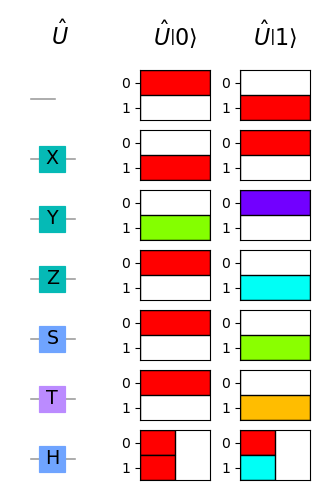

In [5]:
jmax = len(preps)
imax = len(cirs)
psis = np.zeros((imax,jmax), dtype=object)
for j in range(jmax):
  for i in range(imax):
    c = preps[j].copy()
    c.compose (cirs[i], inplace=True)
    c.save_statevector('psi')
    res = sim.run(qiskit.transpile(c,sim)).result()
    psi = getStatevectors(res)
    psis[i,j] = psi[0]
fig,axs = axgrid ([1.0]+jmax*[.7], [.5]+imax*[.5], padl=.3, padt=.1)
axs[0,0].axis('off')
axs[0,0].text (.5, .5, '$\hat{U}$', ha='center', va='center', fontsize=16) 
for j in range(jmax):
  ax = axs[0,1+j]; ax.axis('off'); ax.text (.5, .5, r'$\hat{U}\left|' + f'{j}' + r'\right>$', ha='center', va='center', fontsize=16)
for i in range(imax):
  ax = axs[1+i,0]
  modifyAxSize (ax, *circuitSize(cirs[i]))  
  cirs[i].draw('mpl',ax=ax,**cirOpts,with_layout=False)
  ax.set_xlim (left=-1)  # cut off the redundant 'q' label on the only qubit wire
for j in range(jmax):
  for i in range(imax):
    psi = psis[i,j]
    ax = axs[1+i,1+j]
    plotStatevector (psi,ax=ax,horiz=True) #; ax.set_title ('psi1');
    ax.set_xlim(0,1); ax.set_ylim(-2,0);

In the figure above, the two columns correspond to the 1-qubit quantum computer being prepared in |0> and in |1> respectively.  The rows are the effects of various gates.  Each row of the table is a graphical representation of the matrix of the gate.  For example:

$\qquad$$\begin{align}  \mat{X} = \pmatrix{0 & 1 \\ 1 & 0}   \end{align}$
$\qquad$$\begin{align}  \mat{Y} = \pmatrix{0 & -i \\ i & 0}   \end{align}$
$\qquad$$\begin{align}  \mat{Z} = \pmatrix{1 & 0 \\ 0 & -1}   \end{align}$
$\qquad$$\begin{align}  \mat{H} = \tfrac{1}{\sqrt{2}} \pmatrix{1 & 1 \\ 1 & -1}   \end{align}$

## Parametrized single-qubit gates: P, RX, RY, RZ

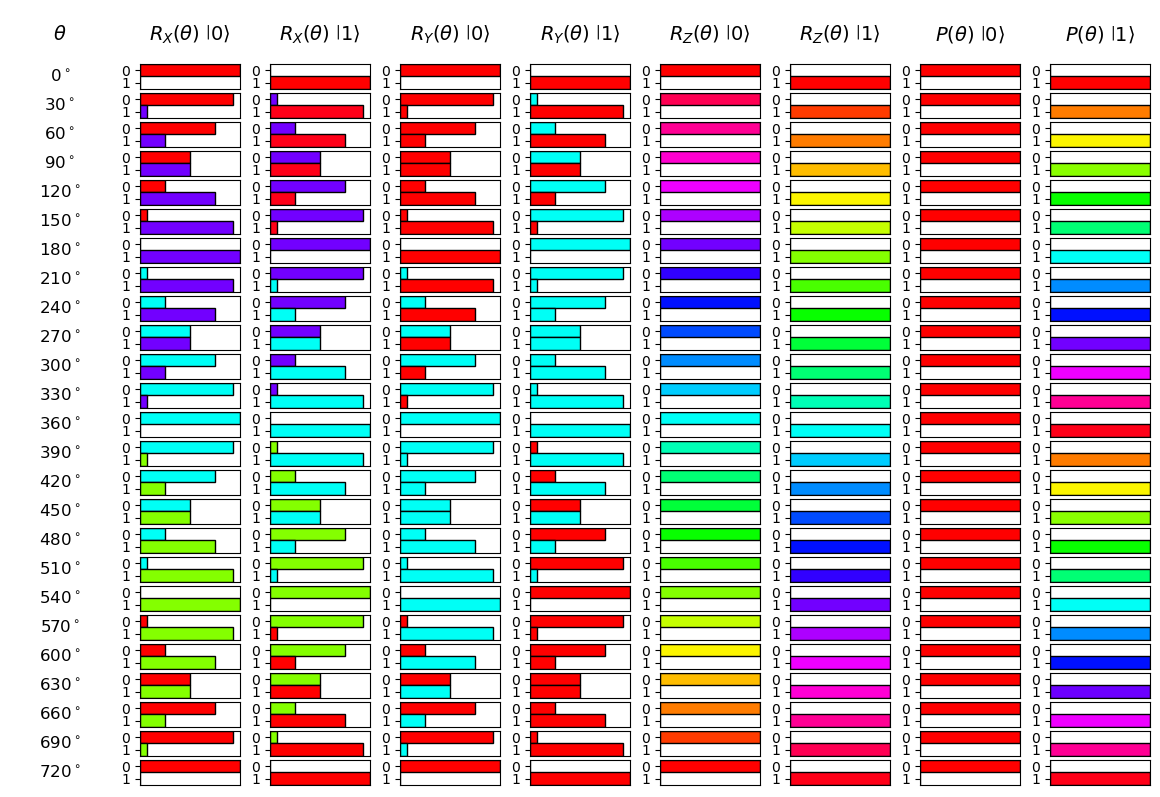

In [6]:
t = qiskit.circuit.Parameter('t')
#========= Circuit for each column
cirj = []
c=qiskit.QuantumCircuit(1);         c.rx(t,0); cirj.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); c.rx(t,0); cirj.append(c.copy())
c=qiskit.QuantumCircuit(1);         c.ry(t,0); cirj.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); c.ry(t,0); cirj.append(c.copy())
c=qiskit.QuantumCircuit(1);         c.rz(t,0); cirj.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); c.rz(t,0); cirj.append(c.copy())
c=qiskit.QuantumCircuit(1);         c.p(t,0); cirj.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); c.p(t,0); cirj.append(c.copy())
ti = list(range(0,721,30))
jmax = len(cirj)
imax = len(ti)
#========= Table of final statevectors
psis = np.zeros((imax,jmax), dtype=object)
for i in range(imax):
  for j in range(jmax):
    c = cirj[j].copy().bind_parameters( { t : np.radians(ti[i]) })   # bound circuit
    c.save_statevector('psi')
    res = sim.run(qiskit.transpile(c,sim)).result()
    psi = getStatevectors(res)
    psis[i,j] = psi[0]
fig,axs = axgrid ([1.0]+jmax*[1], [.5]+imax*[.25], padl=.3, padt=.04)
op = {'ha':'center', 'va':'center', 'fontsize':14}
for ax in axs[0,:]: ax.axis('off')
axs[0,0].text (.5, .5, r'$\theta$', **op)
axs[0,1].text (.5, .5, r'$R_X(\theta)~ \left|0\right>$', **op)
axs[0,2].text (.5, .5, r'$R_X(\theta)~ \left|1\right>$', **op)
axs[0,3].text (.5, .5, r'$R_Y(\theta)~ \left|0\right>$', **op)
axs[0,4].text (.5, .5, r'$R_Y(\theta)~ \left|1\right>$', **op)
axs[0,5].text (.5, .5, r'$R_Z(\theta)~ \left|0\right>$', **op)
axs[0,6].text (.5, .5, r'$R_Z(\theta)~ \left|1\right>$', **op)
axs[0,7].text (.5, .5, r'$P(\theta)~ \left|0\right>$', **op)
axs[0,8].text (.5, .5, r'$P(\theta)~ \left|1\right>$', **op)
for i in range(imax):
  ax = axs[1+i,0]; ax.axis('off')
  ax.text (.5, .5, f'${ti[i]}^\circ$', ha='center', va='center', fontsize=12, transform=ax.transAxes)
for j in range(jmax):
  for i in range(imax):
    psi = psis[i,j]
    ax = axs[1+i,1+j]
    plotStatevector (psi,ax=ax,horiz=True)
    ax.set_xlim(0,1); ax.set_ylim(-2,0)

The single-qubit gates above are represented by the following $2\times 2$ matrices:

$\hspace{2cm}$$\hat{R}_X(\theta)= \pmatrix{\cos\frac{\theta}{2}& -i\sin\frac{\theta}{2}\\-i\sin\frac{\theta}{2}&\cos\frac{\theta}{2}}$
$\hspace{2cm}$$\hat{R}_Y(\theta)= \pmatrix{\cos\frac{\theta}{2}& -\sin\frac{\theta}{2}\\\sin\frac{\theta}{2}&\cos\frac{\theta}{2}}$
$\hspace{2cm}$$\hat{R}_Z(\theta)= \pmatrix{e^{-i\theta/2} & 0 \\ 0 & e^{i\theta/2}}$
$\hspace{2cm}$$\hat{P}(\theta)  = \pmatrix{1& 0 \\ 0 & e^{i\theta}}$.

Note that:

- The $P$ gate leaves $\ket{0}$ invariant and evolves $\ket{1}$ by a phase factor $e^{i\theta}$.
- The $R_Z$ gate evolves $\ket{0}$ and $\ket{1}$ by opposite phase factors: $\hat{R}_Z(\theta) \ket{0} = e^{-i\theta/2} \ket{0} + e^{i\theta/2} \ket{1}$.
- The $R_Y$ gate drives transitions between the two basis states: $\hat{R}_Y(\theta) \ket{0} = \cos\frac{\theta}{2}\ket{0} + \sin\frac{\theta}{2}\ket{1}$.
- The $R_X$ gate is similar to $R_Y$, but is more difficult to interpret because the second state has a phase factor of $i$. 
- The phase gate has a period of $2\pi$: $\hat{P} (360^\circ) = \hat{1}$.
- The rotation gates have periods of $4\pi$: $\hat{R_x} (360^\circ) = \hat{R_y} (360^\circ) = \hat{R_z} (360^\circ) = -\hat{1}$.

## Effect of single-qubit gates on Bloch sphere representation of statevector (TBD)?

To illustrate this, we should initialize a qubit pointing diagonally right and up, and plot the locus of the Bloch vector as RX, RY, or RZ are applied.  We probably want to use Loh's 3D graphics rather than matplotlib 3D.

## Initializing a qubit in a desired state

Define six states in which the Bloch vector points east, west, north, south, up, or down:

$\qquad$$\ket{\text{E}} = \ket{\rightarrow} = \frac{\ket{0} + \ket{1}}{\sqrt{2}}$

$\qquad$$\ket{\text{W}} = \ket{\leftarrow} = \frac{\ket{0} - \ket{1}}{\sqrt{2}}$

$\qquad$$\ket{\text{N}} = \ket{\odot} = \tfrac{1}{\sqrt{2}}(\ket{0} + i?? \ket{1})$

$\qquad$$\ket{\text{S}} = \ket{\otimes} = \tfrac{1}{\sqrt{2}}(\ket{0} - i?? \ket{1})$

$\qquad$$\ket{\text{U}} = \ket{\uparrow} = \ket{0}$

$\qquad$$\ket{\text{D}} = \ket{\downarrow} = \ket{1}$

We may initialize a qubit in each of these states using an appropriate sequence of gates.  

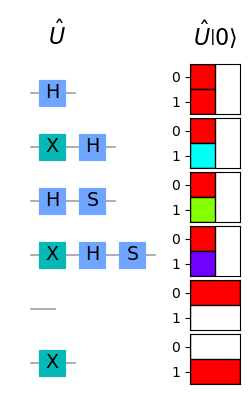

In [7]:
#========= Preparation circuits
preps = []
c=qiskit.QuantumCircuit(1); preps.append(c.copy())
#========= Evolution circuits
cirs = []
c=qiskit.QuantumCircuit(1); c.h(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); c.h(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.h(0); c.s(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); c.h(0); c.s(0); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); cirs.append(c.copy())
c=qiskit.QuantumCircuit(1); c.x(0); cirs.append(c.copy())
#========= Table of final statevectors
jmax = len(preps)
imax = len(cirs)
psis = np.zeros((imax,jmax), dtype=object)
for j in range(jmax):
  for i in range(imax):
    c = preps[j].copy()
    c.compose (cirs[i], inplace=True)
    c.save_statevector('psi')
    res = sim.run(qiskit.transpile(c,sim)).result()
    psi = getStatevectors(res)
    psis[i,j] = psi[0]
fig,axs = axgrid ([1.5]+jmax*[.5], [.5]+imax*[.5], padl=.3, padt=.04)
ax = axs[0,0]; ax.axis('off')
ax.text (0.25, 0.5, '$\hat{U}$', ha='left', va='center', fontsize=16) #, transform=ax.transAxes)
for j in range(jmax):
  ax = axs[0,1+j]; ax.axis('off')
  ax.text (.5, .5, r'$\hat{U}\left|' + f'{j}' + r'\right>$', ha='center', va='center', fontsize=16, transform=ax.transAxes)
for i in range(imax):
  ax = axs[1+i,0]
  modifyAxSize (ax, *circuitSize(cirs[i]))  
  cirs[i].draw('mpl',ax=ax,**cirOpts,with_layout=False)
  ax.set_xlim (left=-1)  # cut off the redundant 'q' label on the only qubit wire
for j in range(jmax):
  for i in range(imax):
    psi = psis[i,j]
    ax = axs[1+i,1+j]
    plotStatevector (psi,ax=ax,horiz=True) #; ax.set_title ('psi1');
    ax.set_xlim(0,1); ax.set_ylim(-2,0);

## Measuring a qubit in the X, Y, or Z basis

Make a table with state preparation circuits in row headings, and measurement circuits in column headings.
Draw the distribution of 1's and 0's in the table. 
Like this:

             MX       MY       MZ
    H        0        ran      ran 
    XH       1        ran      ran
    HS       ran      0        ran
    XHS
    I
    X

## Stern-Gerlach and Malus

Consider setting up a circuit where we set up a spin in the X basis, then  measure in Z, etc.
H gate followed by M...

## BB84